In [1]:
import collections
import networkx as nx
import sys
import os
sys.path.append(r'c:\\Users\\rotim\\OneDrive\\Documents\\Reading\\graph-code\\Skoltech-PhD-Thesis\\_codes\\SIR\\Influential-nodes-identification-in-complex-networks-via-information-entropy')
from algorithms import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle

In [2]:
# data_file = 'topo' # 'HepPh'

# G = clean_data(data_file)
# print(nx.number_of_nodes(G), nx.number_of_edges(G))

graph_collections, graph_name = read_graph("./test-graphs")
# print(graph_name)


{'ABILENE': {'index': 0, 'nodes': 11, 'edges': 14}, 'ABVT': {'index': 1, 'nodes': 23, 'edges': 31}, 'AGIS': {'index': 2, 'nodes': 25, 'edges': 30}, 'ARN.GRAPHML': {'index': 3, 'nodes': 30, 'edges': 29}, 'BELLCANADA': {'index': 4, 'nodes': 48, 'edges': 64}, 'BELLSOUTH.GRAPHML': {'index': 5, 'nodes': 51, 'edges': 66}, 'BICS.GRAPHML': {'index': 6, 'nodes': 33, 'edges': 48}, 'CERNET.GRAPHML': {'index': 7, 'nodes': 41, 'edges': 58}, 'CESNET200706.GRAPHML': {'index': 8, 'nodes': 44, 'edges': 51}, 'CHINANET.GRAPHML': {'index': 9, 'nodes': 42, 'edges': 66}, 'COGENTCO.GRAPHML': {'index': 10, 'nodes': 197, 'edges': 243}, 'COLT.GRAPHML': {'index': 11, 'nodes': 153, 'edges': 177}, 'DELTACOM.GRAPHML': {'index': 12, 'nodes': 113, 'edges': 161}, 'GARR201110.GRAPHML': {'index': 13, 'nodes': 59, 'edges': 74}, 'GEANT2001': {'index': 14, 'nodes': 27, 'edges': 38}, 'GRNET.GRAPHML': {'index': 15, 'nodes': 37, 'edges': 42}, 'INTELLIFIBER.GRAPHML': {'index': 16, 'nodes': 73, 'edges': 95}, 'INTEROUTE.GRAPHML'

Our Model

In [3]:
G = graph_collections[37]
# geo_loc_data = get_geo_data("Internet2LatLong.csv")
geo_loc_data = {k: {"lat": v.get('Latitude', 0), "long": v.get('Longitude', 0)}
                for (k, v) in G.nodes(data=True)}
# print(geo_loc_data)
edge_geo_data_combined = assign_location(G, geo_loc_data)
# set edge attributes
set_edge_attr(G, edge_geo_data_combined)
# obtain the node degrees and edges weights to desired lengths
tmp_t = list(range(1, 5))
tmp_t_SN, tmp_t_hub = hubs_SN_NS(G, tmp_t)
# print(tmp_t_SN, tmp_t_hub)
# G = graph_collections[0]
combined_dict, combined_dict_k_2 = varying_examples(tmp_t_SN[0][1], tmp_t_hub[1][2])

# Get ranked result
opti_rank, ranked_nodes = rank_result(combined_dict, combined_dict_k_2)
# print()
opti_rank
# [e for e in G.edges(data=True)]


[('70', 0.9986942454915201),
 ('52', 0.7269206963021477),
 ('118', 0.6606933873804316),
 ('37', 0.04551598153655445)]

In [4]:
geo_loc_data_all = {i: {k: {"lat": v.get('Latitude', 0), "long": v.get('Longitude', 0)}
     for (k, v) in g.nodes(data=True)} for i, g in zip(graph_name, graph_collections)}
geo_loc_data_all
edge_geo_data_combined_all = {k: assign_location(g, v) for (k, v), g in zip(geo_loc_data_all.items(), graph_collections)}
# print(edge_geo_data_combined_all)
[set_edge_attr(g, v[1]) for (v ,g) in zip(edge_geo_data_combined_all.items(), graph_collections)]

tmp_t = list(range(1, 3))
combi_ = {k: hubs_SN_NS(g, tmp_t) for g,k in zip(graph_collections, graph_name)}
# combi_["ABILENE"]
all_ranks = {k: [rank_result(*varying_examples(v_[0][1], v_[1][2])) for v_ in v]
 for k, v in combi_.items()}
# edge_geo_data_combined_all
# all_ranks


In [5]:
# summary_stat = {k: {"Graph": k,
#     "nodes": nx.number_of_nodes(f), 
#     "egdes": nx.number_of_edges(f), 
#     "density": nx.density(f), 
#     "diameter": nx.diameter(f),
#     "transitivity": nx.transitivity(f),
#     "average path length": nx.average_shortest_path_length(f),
#     "average degree": sum([d for (n, d) in nx.degree(f)]) / float(f.number_of_nodes()),
#     "average weighted degree": sum([q[1] for q in list(f.degree(weight='weight'))])/float(f.number_of_nodes()),
#     "optimal ranks": {*v[0][0]},
#     "node_cluster": cluster_optimal_nodes(f, v[0][0])
#                     } for f, k, (k2, v) in zip(graph_collections, graph_name, all_ranks.items()) if k2 == k}



In [6]:
# df = pd.DataFrame([v for v in summary_stat.values()])
# df.to_csv(r'raw_ranking.csv', index=False, header=True)

In [7]:
max_ = len(opti_rank)/nx.number_of_nodes(G)  # 0.16
max_topk = round(max_ * nx.number_of_nodes(G))
print(max_topk)


4


In [8]:

degreerank = degree(G, max_topk)
print('degreerank: ', degreerank)
degreerank_non = degree_non(G, max_topk)
print('degreerank_non :', degreerank_non)

node_strength_rank_1 = sorted([(i, sum(hub_information(G, i, 1))) for (i, j) in list(G.degree())],
                              key=lambda item: item[1], reverse=True)[:max_topk]
print("node_strength_rank_1: ",node_strength_rank_1)

node_strength_rank_2 = sorted([(i, sum(hub_information(G, i, 2))) for (i, j) in list(G.degree())],
                              key=lambda item: item[1], reverse=True)[:max_topk]
print("node_strength_rank_2: ", node_strength_rank_2)

node_step_nbr_1 = sorted([(i, len(n_neighbor(G, i, 1))) for (i, j) in list(G.degree())],
                         key=lambda item: item[1], reverse=True)[:max_topk]
print("node_step_nbr_1: ",node_step_nbr_1)

node_step_nbr_2 = sorted([(i, len(n_neighbor(G, i, 2))) for (i, j) in list(G.degree())],
                         key=lambda item: item[1], reverse=True)[:max_topk]
print("node_step_nbr_2: ",node_step_nbr_2)


newmethod_rank = EnRenewRank(G, max_topk, 2)
print('newmethod_rank: ', newmethod_rank)

kshell_rank = kshell(G, max_topk)
print('kshell_rank: ', kshell_rank)
kshell_rank_non = kshell_non(G, max_topk)
print('kshell_rank_non: ', kshell_rank_non)


degreerank:  [('46', ' '), ('52', ' '), ('98', ' '), ('25', ' ')]
degreerank_non : [('46', ' '), ('52', ' '), ('98', ' '), ('25', ' ')]
node_strength_rank_1:  [('54', 139.08300000000003), ('70', 138.139), ('118', 135.765), ('52', 76.12100000000001)]
node_strength_rank_2:  [('70', 630.637), ('118', 552.493), ('52', 167.53800000000004), ('54', 158.95100000000002)]
node_step_nbr_1:  [('46', 6), ('52', 6), ('98', 6), ('25', 5)]
node_step_nbr_2:  [('52', 14), ('71', 14), ('95', 14), ('46', 13)]
newmethod_rank:  [('95', 0.4558122480146817), ('52', 0.3988926042887207), ('46', 0.3928992277793086), ('98', 0.37400705610499774)]
kshell_rank:  [('46', ' '), ('52', ' '), ('98', ' '), ('25', ' ')]
kshell_rank_non:  [('46', ' '), ('52', ' '), ('98', ' '), ('25', ' ')]


## Different Lambda $(\lambda)$

In [9]:
infect_prob = compute_probability(G) * 1.5
avg = 100
max_iter = 200000
topk = round(max_ * nx.number_of_nodes(G))


In [10]:

degreerank_result = []
degreerank_non_result = []
vote_result = []
vote_non_result = []
newmethod_result = []
newmethod_non_result = []
kshell_result = []
kshell_non_result = []
evbrM_result = []
node_strength_rank_1_result = []
node_strength_rank_2_result = []
node_step_nbr_1_result = []
node_step_nbr_2_result = []
# atio = [a/10 for a in list(range(10, 21, 2))]

for a in tqdm(range(10, 21, 2)):
    atio = a / 10
    cover_prob = infect_prob / atio
    degreerank_result.append(get_sir_result(G, degreerank, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    # degreerank_non_result.append(get_sir_result(G, degreerank_non, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    # vote_result.append(get_sir_result(G, vote, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    # vote_non_result.append(get_sir_result(G, vote_non, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    newmethod_result.append(get_sir_result(G, newmethod_rank, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    kshell_result.append(get_sir_result(G, kshell_rank, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    kshell_non_result.append(get_sir_result(G, kshell_rank_non, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    evbrM_result.append(get_sir_result(G, opti_rank, topk, avg,infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    node_strength_rank_1_result.append(get_sir_result(G, node_strength_rank_1, topk, avg,infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    node_strength_rank_2_result.append(get_sir_result(G, node_strength_rank_2, topk, avg,infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    node_step_nbr_1_result.append(get_sir_result(G, node_step_nbr_1, topk, avg,infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    node_step_nbr_2_result.append(get_sir_result(G, node_step_nbr_2, topk, avg,infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))


100%|██████████| 6/6 [00:04<00:00,  1.22it/s]


In [11]:
%matplotlib inline
plt.title('network:{}   avg:{}  max:{}   infect_prob:{}'.format(data_file, avg, max_, infect_prob))
plt.plot(np.array(range(10, 21, 2)) / 10, degreerank_result, 'r-o', label='degree', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, degreerank_non_result, 'r--o', label='degree_non', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, vote_result, 'y-s', label='vote', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, vote_non_result, 'y--s', label='vote_non', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, newmethod_result, 'b-^', label='EnRenew', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, kshell_result, 'g-p', label='kshell', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, kshell_non_result, 'g--p', label='kshell_non', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, evbrM_result, 'c--o', label='evbrM', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, node_strength_rank_1_result, 'b--o', label='ns_1', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, node_strength_rank_2_result, 'b-o', label='ns_2', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, node_step_nbr_1_result, 'g--o', label='sn_1', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, node_step_nbr_2_result, 'g-o', label='sn_2', linewidth=1.0, )
plt.legend(loc="upper left")
plt.ylabel("$F(t_c)$")
plt.xlabel('$p$')
plt.show()


NameError: name 'data_file' is not defined

In [ ]:
node_cluster = cluster_optimal_nodes(G, opti_rank)
node_cluster

[('6', set()), ('3', {'0', '1'}), ('5', {'2', '4'})]

In [ ]:
cover_prob = [infect_prob / a/10 for a in range(10, 21, 2)]
node_count = nx.number_of_nodes(G)


In [ ]:
closeness_centrality_result = [(get_sir_result( G, closeness_centrality, topk, avg, infect_prob, a, max_iter)[-1] / node_count) for a in tqdm(cover_prob)]
degree_centrality_result = [(get_sir_result( G, degree_centrality, topk, avg, infect_prob, a, max_iter)[-1] / node_count) for a in tqdm(cover_prob)]
eigenvector_centrality_result = [(get_sir_result( G, eigenvector_centrality, topk, avg, infect_prob, a, max_iter)[-1] / node_count) for a in tqdm(cover_prob)]
load_centrality_result = [(get_sir_result( G, load_centrality, topk, avg, infect_prob, a, max_iter)[-1] / node_count) for a in tqdm(cover_prob)]
betweenness_centrality_result = [(get_sir_result( G, betweenness_centrality, topk, avg, infect_prob, a, max_iter)[-1] / node_count) for a in tqdm(cover_prob)]
current_flow_betweenness_centrality_result = [(get_sir_result( G, current_flow_betweenness_centrality, topk, avg, infect_prob, a, max_iter)[-1] / node_count) for a in tqdm(cover_prob)]
approximate_current_flow_betweenness_centrality_result = [(get_sir_result( G, approximate_current_flow_betweenness_centrality, topk, avg, infect_prob, a, max_iter)[-1] / node_count) for a in tqdm(cover_prob)]
# betweenness

100%|██████████| 6/6 [00:42<00:00,  7.10s/it]


 50%|█████     | 3/6 [11:55<11:55, 238.41s/it]


TypeError: unhashable type: 'numpy.ndarray'

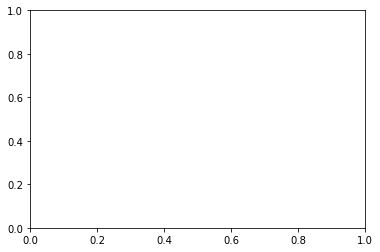

In [ ]:
%matplotlib inline
# plt.title('network:{}   avg:{}  max:{}   infect_prob:{}'.format(data_file, avg, max_, infect_prob))
# plt.plot(np.array(range(10, 21, 2)) / 10, degreerank_result, 'r-o', label='degree', linewidth=1.0, )
# # plt.plot(np.array(range(10, 21, 2)) / 10, degreerank_non_result, 'r--o', label='degree_non', linewidth=1.0, )
# # plt.plot(np.array(range(10, 21, 2)) / 10, vote_result, 'y-s', label='vote', linewidth=1.0, )
# # plt.plot(np.array(range(10, 21, 2)) / 10, vote_non_result, 'y--s', label='vote_non', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, newmethod_result, 'b-^', label='EnRenew', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, kshell_result, 'g-p', label='kshell', linewidth=1.0, )
# # plt.plot(np.array(range(10, 21, 2)) / 10, kshell_non_result, 'g--p', label='kshell_non', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, opti_rank, 'c--o', label='evbrM', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, closeness_centrality_result, 'b--o', label='ns_1', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, degree_centrality_result, 'b-o', label='ns_2', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, eigenvector_centrality_result, 'g--o', label='sn_1', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, load_centrality_result, 'g-o', label='sn_2', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, betweenness_centrality_result, 'b-^', label='EnRenew', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, current_flow_betweenness_centrality_result, 'g-p', label='kshell', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, approximate_current_flow_betweenness_centrality_result, 'r-o', label='degree', linewidth=1.0, )
plt.legend(loc="upper left")
plt.ylabel("$F(t_c)$")
plt.xlabel('$p$')
plt.show()
